In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn

sys.path.append("../functions")

from Utility import *
from Plotting import *

%matplotlib inline
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


## Reading Data


In [2]:
raw_data = pd.read_csv("../data/twoArmedandit_with_confidence.csv")
# selecting usefull columns
data = raw_data[
    [
        "sub",
        "condition",
        "cresp",
        "resp",
        "cor",
        "cj",
        "phase",
        "trial",
        "trial_rev",
        "reward",
        "Lreward",
        "Hreward",
    ]
]
# excluding chance level subjects
chance_level_subjects = [45634, 46069, 46279, 46303, 46651, 47398]

# selecting portion of data with proper task
lv_induction_data = data[
    (data["phase"] == "induction")
    & (data["condition"] == "hc")
    & (~data["sub"].isin(chance_level_subjects))
]
subjects = lv_induction_data["sub"].unique()

In [3]:
forward_df = pd.read_csv("../results/forward_df.csv")
backward_df = pd.read_csv("../results/backward_df.csv")

## Simulate With Fitted Params

In [ ]:
from Forward import simulate_with_params
from Utility import merge_result_df


np.random.seed(1)
forward_simulation_df = simulate_with_params(forward_df, lv_induction_data, subjects)
backward_simulation_df = simulate_with_params(backward_df, lv_induction_data, subjects)
forward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
backward_simulation_df.rename(columns={"sub": "subject"}, inplace=True)
human_lv_df = lv_induction_data.rename(columns={"sub": "subject"})

In [5]:
subjects_avg_df = (
    human_lv_df.groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)
forward_avg_df = (
    forward_simulation_df.groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)
backward_avg_df = (
    backward_simulation_df.groupby("subject")
    .agg({"reward": "mean", "cor": "mean", "cj": "mean"})
    .reset_index()
)
groups = ["Forward", "Empirical", "Backward"]

avg_df = merge_result_df(
    [forward_avg_df, subjects_avg_df, backward_avg_df], groups, 200, subjects
)
avg_df.rename(
    columns={"reward": "mean_reward", "cor": "accuracy", "cj": "mean conf"},
    inplace=True,
)

Statistics=12.5, p=3.2554038825015253e-10
Statistics=20.0, p=7.39351066054678e-10
Statistics=266.0, p=6.897745487195979e-05


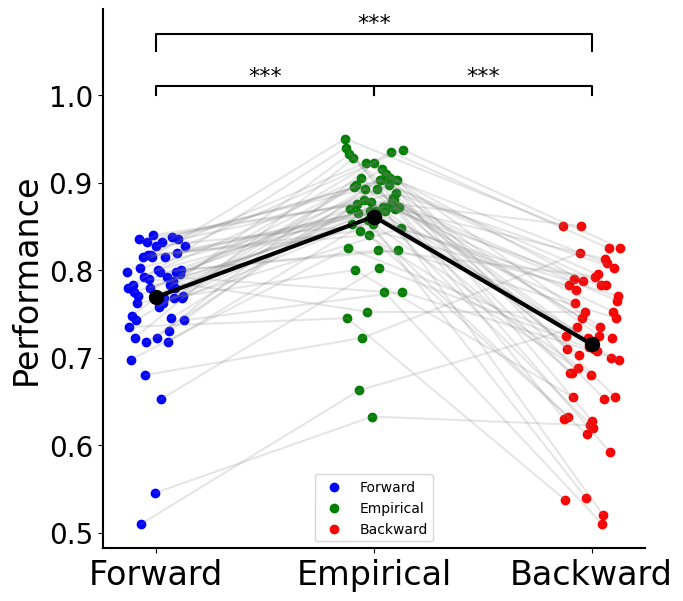

In [6]:
plt.figure(figsize=(7, 7))
comparison_plot(
    avg_df,
    "accuracy",
    groups,
    "",
    [["Empirical", "Forward"], ["Backward", "Empirical"], ["Forward", "Backward"]],
    [1, 1, 1.05],
    [0.01, 0.01, 0.02],
    y_label="Performance",
)
plt.savefig("../figs/accuracy_compare.png", dpi=400)

Statistics=609.0, p=0.2503646607243436
Statistics=451.0, p=0.012077269223755682
Statistics=529.0, p=0.06602092948730907


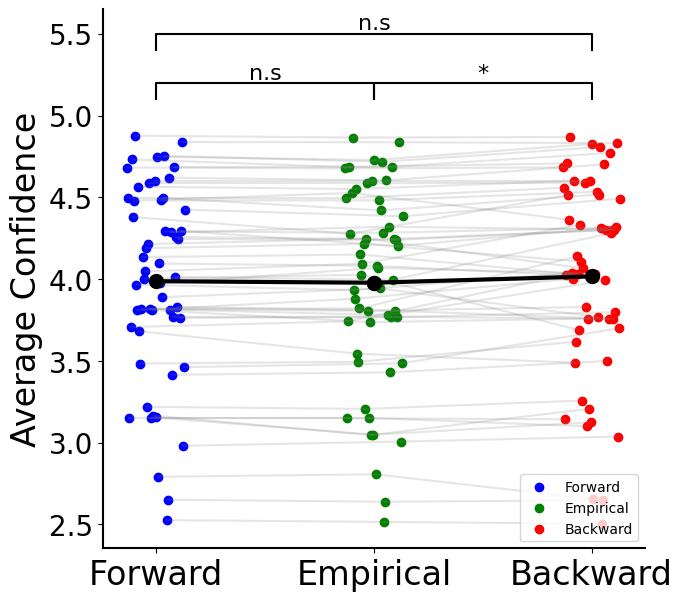

In [7]:
plt.figure(figsize=(7, 7))

comparison_plot(
    avg_df,
    "mean conf",
    groups,
    "",
    [["Empirical", "Forward"], ["Backward", "Empirical"], ["Forward", "Backward"]],
    [5.1, 5.1, 5.4],
    [0.1, 0.1, 0.1],
    legend="lower right",
    y_label="Average Confidence",
)

plt.savefig("../figs/mean_confs_compare.png", dpi=400)

Statistics=0.0, p=1.6256984569330967e-10


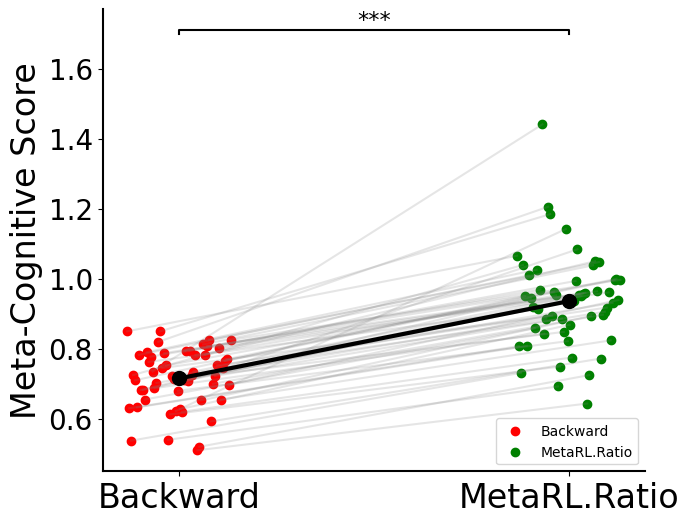

In [14]:
plt.figure(figsize=(7, 6))

mrl_df = forward_avg_df.copy()
mrl_df["cor"] = backward_avg_df["cor"] / forward_avg_df["cor"]

groups = ["Backward", "MetaRL.Ratio"]

measure_compare_df = merge_result_df([backward_avg_df, mrl_df], groups, 200, subjects)
comparison_plot(
    measure_compare_df,
    "cor",
    groups,
    "",
    [groups],
    [1.7],
    [0.01],
    y_label="Meta-Cognitive Score",
)
plt.savefig("../figs/Meta_Cognitive_Score.png", dpi=400)

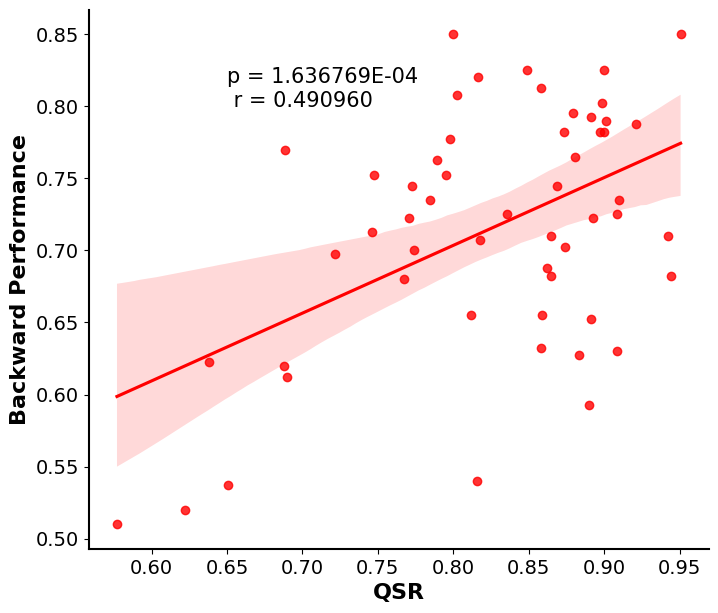

In [15]:
plt.figure(figsize=(8, 7))

emp_qsr_df = (
    lv_induction_data.groupby("sub")
    .apply(group_qsr)
    .reset_index()
    .rename(columns={0: "QSR", "sub": "subject"})
)
backward_emp_qsr = pd.merge(backward_avg_df, emp_qsr_df, on=["subject"])
forward_emp_qsr = pd.merge(forward_avg_df, emp_qsr_df, on=["subject"])
backward_emp_qsr["forward_cor"] = forward_emp_qsr["cor"]
backward_emp_qsr["backward/forward"] = (
    backward_emp_qsr["cor"] / backward_emp_qsr["forward_cor"]
)


seaborn.regplot(
    data=backward_emp_qsr, x="QSR", y="cor", label="Backward Performance", color="red"
)

stat, pval = scipy.stats.pearsonr(backward_emp_qsr["QSR"], backward_emp_qsr["cor"])

plt.ylabel("Backward Performance", fontsize=16, fontweight="bold")
plt.xlabel("QSR", fontsize=16, fontweight="bold")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.65, 0.8, "p = {:E} \n r = {:f}".format(pval, stat), fontsize=15)

plt.savefig("../figs/Perf_Qsr_reg.png", dpi=400)

plt.show()

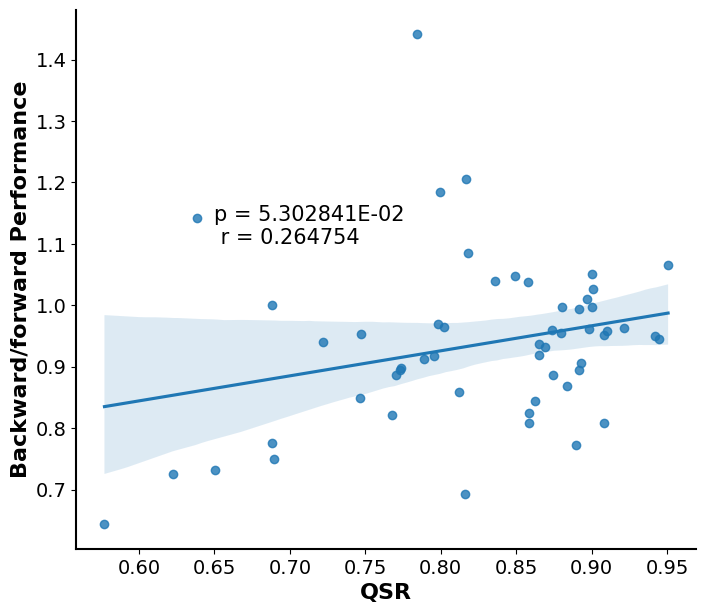

In [24]:
plt.figure(figsize=(8, 7))

backward_emp_qsr = backward_emp_qsr.rename(columns={"cor": "backward_cor"})
perf_qsr_df = pd.merge(backward_emp_qsr, forward_avg_df, on=["subject"])
perf_qsr_df["perf"] = perf_qsr_df["backward_cor"] / perf_qsr_df["cor"]

stat, pval = scipy.stats.pearsonr(perf_qsr_df["QSR"], perf_qsr_df["perf"])


seaborn.regplot(data=perf_qsr_df, x="QSR", y="perf")

plt.ylabel("Backward/forward Performance", fontsize=16, fontweight="bold")
plt.xlabel("QSR", fontsize=16, fontweight="bold")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.text(0.65, 1.1, "p = {:E} \n r = {:f}".format(pval, stat), fontsize=15)


plt.savefig("../figs/Meta_RL_QSR_reg.png", dpi=400)

plt.show()

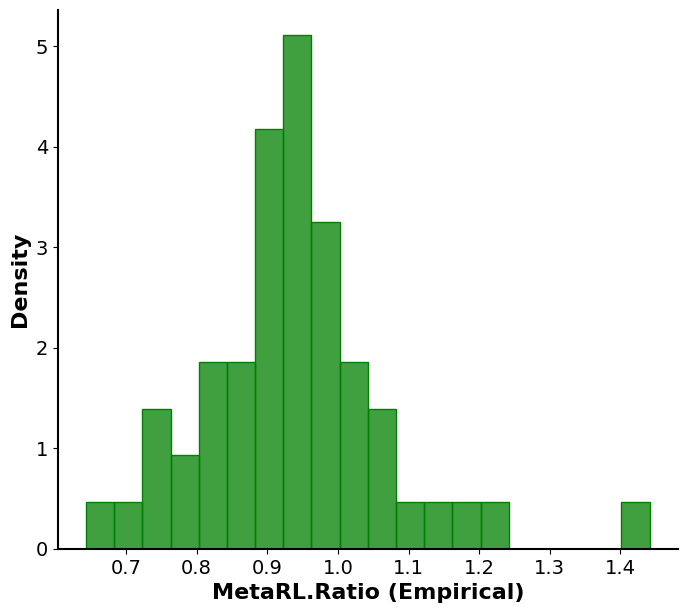

In [25]:
plt.figure(figsize=(8, 7))

seaborn.histplot(
    data=perf_qsr_df,
    x="perf",
    color="green",
    stat="density",
    bins=20,
    edgecolor="green",
)

plt.ylabel("Density", fontsize=16, fontweight="bold")
plt.xlabel("MetaRL.Ratio (Empirical)", fontsize=16, fontweight="bold")

ax = plt.gca()
# hide x-axis
for axis in ["top", "bottom", "left", "right"]:
    ax.spines[axis].set_linewidth(1.5)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig("../figs/Meta_RL_hist.png", dpi=400)

plt.show()